In [11]:
df_1 = pd.read_pickle('/app/data/output/routing_matrix/Transporte publico.pkl')
df_2 = pd.read_pickle('/app/data/output/routing_matrix/Transporte publico_full.pkl')

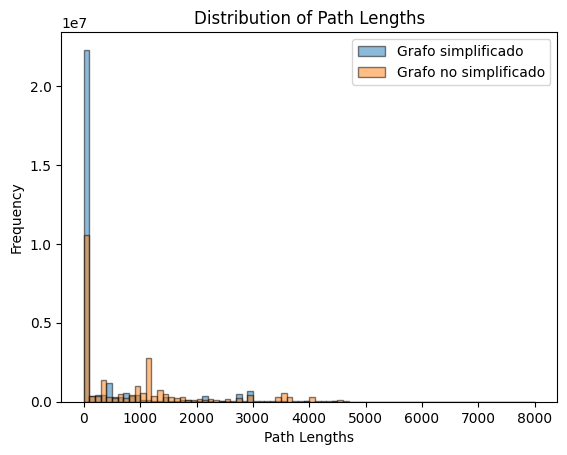

In [18]:
_init = 0
_end = 8000
_step = 100
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Definir los bins
bins = range(_init, _init + _end + _step, _step)

# Plotear los histogramas de ambos dataframes
ax.hist(df_1['path_lengths'], bins=bins, alpha=0.5, label='Grafo simplificado', edgecolor='black')
ax.hist(df_2['path_lengths'], bins=bins, alpha=0.5, label='Grafo no simplificado', edgecolor='black')

# Agregar etiquetas y título
ax.set_xlabel('Path Lengths')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Path Lengths')
ax.legend()

# Mostrar el gráfico
plt.show()

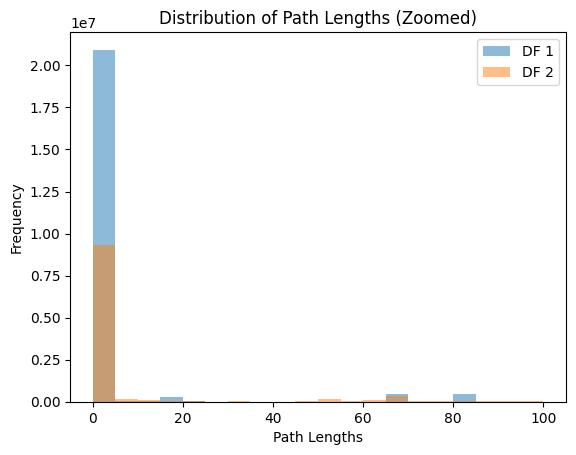

In [19]:
_init = 0
_end = 100
_step = 5
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Definir los bins
bins = range(_init, _init + _end + _step, _step)

# Plotear los histogramas de ambos dataframes
ax.hist(df_1[df_1['path_lengths'] < 100]['path_lengths'], bins=bins, alpha=0.5, label='DF 1')
ax.hist(df_2[df_2['path_lengths'] < 100]['path_lengths'], bins=bins, alpha=0.5, label='DF 2')

# Agregar etiquetas y título
ax.set_xlabel('Path Lengths')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Path Lengths (Zoomed)')
ax.legend()

# Mostrar el gráfico
plt.show()

In [20]:
%pip install taxicab


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as  plt

In [2]:
df = pd.read_pickle('/app/data/output/routing_matrix/Transporte publico_full.pkl')

In [17]:
df = df[df['rank']==0]
group_cols = ['origin', 'destination', 'grid_id']
df = df.groupby(group_cols)['path_lengths'].first().reset_index()

In [18]:
grid = gpd.read_file('/app/data/input/grilla50_urbano_extendido').to_crs(4326)
cost = gpd.read_file('/app/data/input/costanera_area').to_crs(4326)

In [19]:
grid.drop(['Id'], axis='columns', inplace=True)
grid['grid_id'] = grid.index

In [20]:
gdf = pd.merge(grid, df, on='grid_id')

In [21]:
gdf_cost = gpd.sjoin(gdf, cost, op='within')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

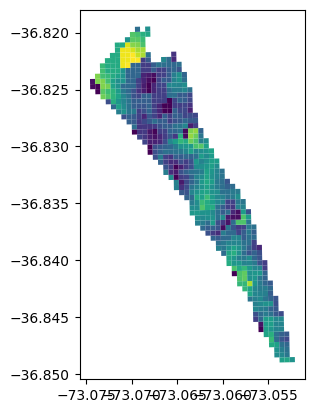

In [22]:
gdf_cost.plot(column='path_lengths')

In [42]:
descr = gdf_cost['path_lengths'].describe()
key_values = ['min', '25%', '50%', '75%']
gdf_cost['tag'] = np.nan
assign_tag = 0
for k in key_values:
    value = descr[k]
    mask = gdf_cost['path_lengths'] >= value
    gdf_cost.loc[mask, 'tag'] = assign_tag
    assign_tag+=1

In [58]:
path = '/app/data/input/Paraderos_2019/Paraderos_2019.shp'
gdf_bus = gpd.read_file(path)
gdf_bus['Category'] = "Transporte publico"
gdf_bus['source'] = 'GTFS'
gdf_bus['id'] = gdf_bus['stop_id']
gdf_bus['type'] = 'transportation'
gdf_bus['Subcategory'] = "bus_stop"
gdf_bus.rename(columns={'stop_name':'name'}, inplace=True)
gdf_bus = gpd.sjoin(gdf_bus, cost, op='within')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

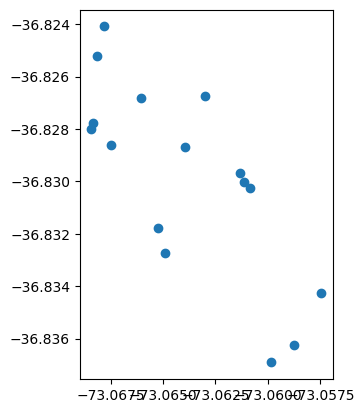

In [45]:
gdf_bus.plot()

/tmp/ipykernel_293/2735984971.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mapper, shrink=0.5)


[0. 1. 2. 3.]


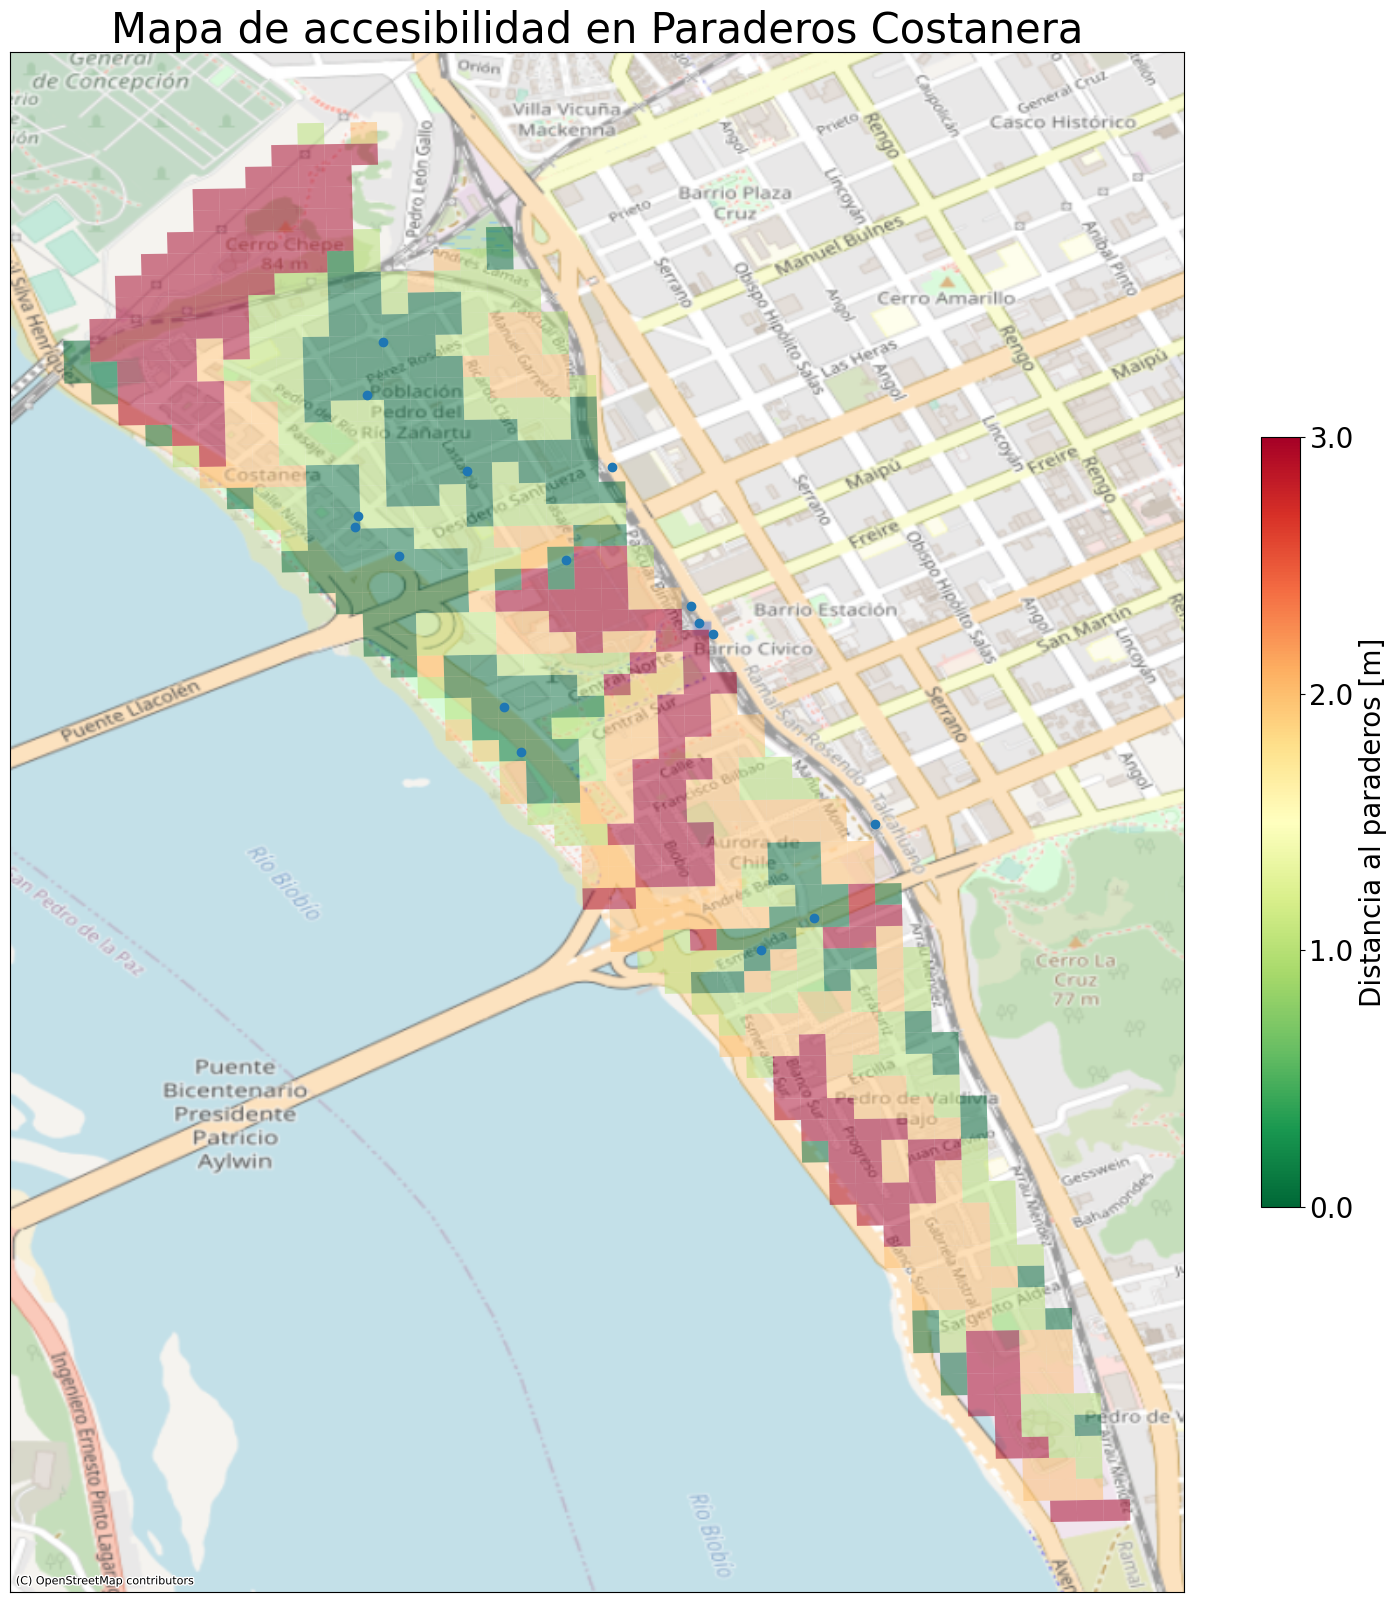

In [59]:
(h, w) = (20, 20)
fig, ax = plt.subplots(figsize=(h, w))

# Rango deseado para la escala de colores
vmin = gdf_cost['tag'].min()
vmax = gdf_cost['tag'].max()
cmap = 'RdYlGn_r'  # Utilizamos el colormap 'RdYlBu'
import matplotlib.colors as mcolors

# Normalizar los valores de 'travel_time' para asegurar que estén dentro del rango de colores
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plotear las geometrías con los colores según 'travel_time'
gdf_cost.plot(ax=ax, column='tag', cmap=cmap, linewidth=0.8, edgecolor='none', norm=norm, alpha=0.5)
gdf_bus.plot(ax=ax)

# Ajustar la escala de la barra de colores
cbar = fig.colorbar(mapper, shrink=0.5)
cbar.set_label('Distancia al paraderos [m]', size=20)  # Etiqueta de la barra de colores
import numpy as np
ticks = np.arange(vmin, vmax+1, 1)
print(ticks)
cbar.set_ticks(ticks)  # Puedes personalizar los ticks de la barra
str_ticks = [str(n) for n in ticks]
# str_ticks[-1] = f'{vmax}+'
cbar.set_ticklabels(str_ticks)  # Personalizar los valores de los ticks
cbar.ax.tick_params(labelsize=20)

# Agrega un mapa de fondo utilizando contextily
ctx.add_basemap(
    ax=ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=gdf.crs.to_string(),
    alpha=0.7
)
plt.title(f'Mapa de accesibilidad en Paraderos Costanera', size=30)
plt.xticks([])
plt.yticks([])
plt.show()

In [56]:
gdf_cost.to_file('/app/data/output/paraderos_costanera')

/tmp/ipykernel_293/919698294.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_cost.to_file('/app/data/output/paraderos_costanera')
